<a href="https://colab.research.google.com/github/ShreyanshJoshi/Temp/blob/master/Copy_of_Copy_of_UTK_Face_dataset_Age%2C_Gender%2C_Race_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Essential libraries
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
dataset_folder_name = '/content/drive/My Drive/Colab Notebooks/UTKFace'
TRAIN_TEST_SPLIT = 0.8
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id)
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id)

In [0]:
# Let's also define a function to help us on extracting the data from our dataset. This function will be used to iterate over each file of the UTK dataset and return a Pandas
#  Dataframe containing all the fields (age, gender and sex) of our records.

def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    
   
    df = df.dropna()
    
    return df

In [11]:
df = parse_dataset(dataset_folder_name)
df.head()

# Now we have a pandas dataframe with us. This can be dealt with quite easily. Like, we simply now need to OHE gender, race and feed it into model
# Using Pandas dataframe also allows me to manipulate and visualize data by plotting graphs.

,age,gender,race,file
0,17.0,male,others,/content/drive/My Drive/Colab Notebooks/UTKFac...
1,17.0,female,white,/content/drive/My Drive/Colab Notebooks/UTKFac...
2,17.0,male,others,/content/drive/My Drive/Colab Notebooks/UTKFac...
3,17.0,female,white,/content/drive/My Drive/Colab Notebooks/UTKFac...
4,17.0,male,others,/content/drive/My Drive/Colab Notebooks/UTKFac...


In [12]:
df.tail()

,age,gender,race,file
23706,2.0,male,indian,/content/drive/My Drive/Colab Notebooks/UTKFac...
23707,1.0,female,indian,/content/drive/My Drive/Colab Notebooks/UTKFac...
23708,2.0,female,indian,/content/drive/My Drive/Colab Notebooks/UTKFac...
23709,1.0,female,indian,/content/drive/My Drive/Colab Notebooks/UTKFac...
23710,2.0,female,indian,/content/drive/My Drive/Colab Notebooks/UTKFac...


(array([3413., 2631., 9066., 3140., 2688., 1398.,  854.,  446.,   54.,
          18.]),
 array([  1. ,  12.5,  24. ,  35.5,  47. ,  58.5,  70. ,  81.5,  93. ,
        104.5, 116. ]),
 <a list of 10 Patch objects>)

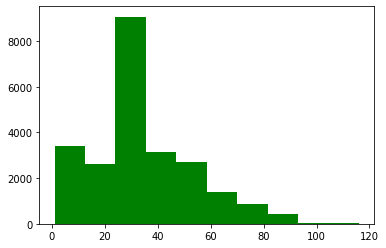

In [0]:
ages = df['age']
nbins = 10
plt.hist(ages,nbins,color='green',histtype='bar')

# Majority population lies between 20-30 age group

([<matplotlib.patches.Wedge at 0x7f55af8b9978>,
 [Text(-0.09437398906673042, 1.3166220225211307, 'male'),
  Text(0.09437411233778002, -1.3166220136851945, 'female')])

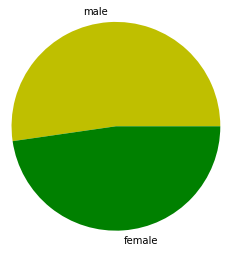

In [0]:
x = (df.gender=='male').sum()
y = (df.gender=='female').sum()
gender = [x,y]
labels = ['male','female']
colors = [ 'y', 'g'] 
plt.pie(gender,labels = labels,colors = colors,radius=1.2)

# Uniform distribution to large extent. Although, males slightly exceed females in numbers

([<matplotlib.patches.Wedge at 0x7f55af87dc88>,
 [Text(0.307280356144906, 1.2837362590218677, 'white'),
  Text(-1.3088853498628525, -0.17093607259557106, 'black'),
  Text(-0.4971320560784433, -1.222808128374693, 'asian'),
  Text(0.7405722442839687, -1.0926814499185964, 'indian'),
  Text(1.2869604383618487, -0.29348395201693445, 'others')])

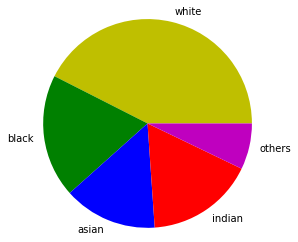

In [0]:
x = (df.race=='white').sum()
y = (df.race=='black').sum()
z = (df.race=='asian').sum()
a = (df.race=='indian').sum()
b = (df.race=='others').sum()

gender = [x,y,z,a,b]
labels = ['white','black','asian','indian','others']
colors = [ 'y', 'g','b','r','m'] 
plt.pie(gender,labels = labels,colors = colors,radius=1.2)

# Uniform distribution to large extent. Although, males slightly exceed females in numbers

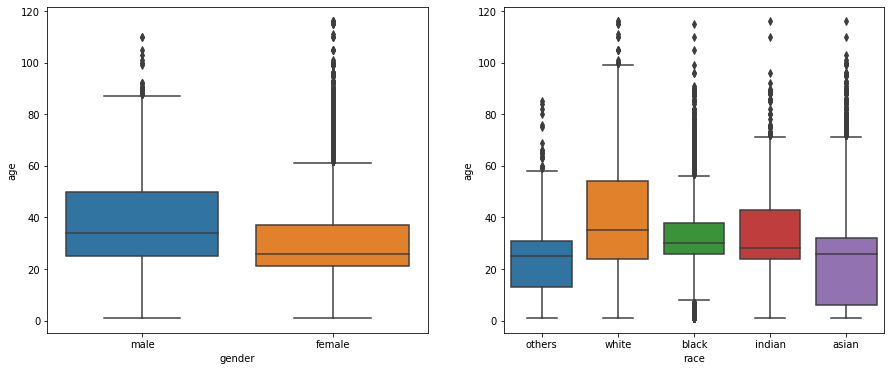

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

# We see that most of males are between 25 and 55, whereas most of the females are between 20 and 35
# Even while groouping by race, we find good amount of variations in different races

In [0]:
df['age'] = df['age']//25

In [31]:
x = (df.age==0).sum()
y = (df.age==1).sum()
z = (df.age==2).sum()
a = (df.age==3).sum()
b = (df.age==4).sum()

print(x,' ',y,' ',z,' ',a,' ',b)


9924   9778   3182   824   0


In [32]:
df.head()

,age,gender,race,file
0,0.0,male,others,/content/drive/My Drive/Colab Notebooks/UTKFac...
1,0.0,female,white,/content/drive/My Drive/Colab Notebooks/UTKFac...
2,0.0,male,others,/content/drive/My Drive/Colab Notebooks/UTKFac...
3,0.0,female,white,/content/drive/My Drive/Colab Notebooks/UTKFac...
4,0.0,male,others,/content/drive/My Drive/Colab Notebooks/UTKFac...


## Data Generator
In order to input our data to our Keras multi-output model, we have a helper object to work as a data generator for our dataset. This will be done by generating batches of data, which will be used to feed our multi-output model with both the images and their labels (instead of just loading all the dataset into the memory at once, which might lead to an out of memory error).

In [0]:
from keras.utils import to_categorical
from PIL import Image
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)      # Splitting into train and test sets
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)       # Further splitting train set into train and validation set
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

# converts alias to id
df['gender_id'] = df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
df['race_id'] = df['race'].map(lambda race: dataset_dict['race_alias'][race])

# Now we got train_idx, valid_idx, test_idx
            
def preprocess_image(img_path):
    """
    Used to perform some minor preprocessing on the image before inputting into the network.
    """
    im = Image.open(img_path)
    im = im.resize((IM_WIDTH, IM_HEIGHT))
    im = np.array(im) / 255.0
    
    return im
        
def generate_images(image_idx, is_training, batch_size=16):
    """
    Used to generate a batch with images when training/testing/validating our Keras model.
    """
    
    # arrays to store our batched data
    images, ages, races, genders = [], [], [], []
    while True:
        for idx in image_idx:
            person = df.iloc[idx]
            
            age = person['age']
            race = person['race_id']
            gender = person['gender_id']
            file = person['file']
            
            im = preprocess_image(file)
            
            races.append(to_categorical(race, len(dataset_dict['race_id'])))
            genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
            ages.append(to_categorical(age,5))
            images.append(im)
            
            # yielding condition
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
                
        if not is_training:
            break
            

In [0]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

"""
  Now we generate our multi-output model. This CNN contains three branches, one for age, other for 
sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
on the make_default_hidden_layers method.
"""
def make_default_hidden_layers(inputs):
    """
    Used to generate a default set of hidden layers. The structure used in this network is defined as:        
    Conv2D -> BatchNormalization -> Pooling -> Dropout

    Note that, generally number of filters increase with depth of network. So, have i done here.
    """
    x = Conv2D(16, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    ''' It's always better not to regularize initial layers in a ConvNet as they learn the fundamentals of images. So, regularizing them should be 
      minimum, else they might not be able to learn important features properly, which essentiallly could lead to underfitting. '''

    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    return x
# I found, race and age branch to learn slowly. Accuracy on training set was improving slowly. 1 probable reason for this
# could be because of more number of classes to predict (in some sense, regressing over ages is equivalent to classifying in 100
# classes). Hence I decided not to regularize these by using Dropout. 

def build_race_branch(inputs, num_races):
    """
    Used to build the race branch of our face recognition network.
    This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
    followed by the Dense output layer.
    """
    x = make_default_hidden_layers(inputs)

    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dense(num_races)(x)
    x = Activation("softmax", name="race_output")(x)

    return x

def build_gender_branch(inputs, num_genders=2):
    """
    Used to build the gender branch of our face recognition network.
    This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
    followed by the Dense output layer.
    """
    x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

    x = make_default_hidden_layers(inputs)

    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.35)(x)
    x = Dense(num_genders)(x)
    x = Activation("sigmoid", name="gender_output")(x)

    return x

def build_age_branch(inputs):   
    """
    Used to build the age branch of our face recognition network.
    This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
    followed by the Dense output layer.

    """
    x = make_default_hidden_layers(inputs)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dense(5)(x)
    x = Activation("softmax", name="age_output")(x)                  # Treating age prediction as a classification problem here.

    return x

def assemble_full_model(width, height, num_races):
    """
    Used to assemble our multi-output model CNN.
    """
    input_shape = (height, width, 3)

    inputs = Input(shape=input_shape)

    age_branch = build_age_branch(inputs)
    race_branch = build_race_branch(inputs, num_races)
    gender_branch = build_gender_branch(inputs)

    model = Model(inputs=inputs, outputs = [age_branch, race_branch, gender_branch], name="face_net")

    return model
    
model = assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=len(dataset_dict['race_alias']))

In [0]:
# LR is perhaps most important hyperparameter to tune. High LR speeds up learning but at the cost of instability,
# whereas, a low LR would take lot of time to progress

init_lr = 8e-4          
epochs = 20
from keras.optimizers import Adam

opt = Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'categorical_crossentropy', 
                  'race_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy'},
              metrics={
                  'age_output': 'accuracy', 
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

## Some key points to remember


*   **ModelCheckpoint** - ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved. This is very essential as DL models can take upto days to train. By default - it's NULL.

    By keeping the filename constant throughout training, we ensure that only the best model weights remain in the file uptill the point we have trained.   
To load weights - `model.load_weights(filepath)`

---



*  **Fit function** -  In the latest version of TF - 2.2.0v (released May 2020), the *fit* function has replaced the *fit_generator* function present before.

---


*  **Validation while training** - All the VALIDATION things, in the *fit* function are related to data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data 






In [69]:
from keras.callbacks import ModelCheckpoint

batch_size = 16
train_gen = generate_images(train_idx, is_training=True, batch_size=batch_size)
''' Since, train_idx is too large to fit inside RAM at once, we generate batches of size 16 from it (called train_gen))'''

# valid_batch_size = 32
# valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

filepath = "./model_checkpoint"
callbacks = [ ModelCheckpoint(filepath, monitor='val_loss') ]
 

history = model.fit(train_gen, steps_per_epoch = 50, epochs=epochs, callbacks=callbacks )

# Ideally, steps_per_epoch = (training size)//(batch size). For computational limitations, I took a much smaller value, 50.


Epoch 1/20
50/50 [==============================] - 15s 291ms/step - loss: 2.0559 - age_output_loss: 0.8708 - race_output_loss: 0.8091 - gender_output_loss: 0.3759 - age_output_accuracy: 0.6175 - race_output_accuracy: 0.7000 - gender_output_accuracy: 0.8250
Epoch 2/20
50/50 [==============================] - 10s 198ms/step - loss: 2.0695 - age_output_loss: 0.8934 - race_output_loss: 0.8094 - gender_output_loss: 0.3667 - age_output_accuracy: 0.6025 - race_output_accuracy: 0.7250 - gender_output_accuracy: 0.8425
Epoch 3/20
50/50 [==============================] - 10s 196ms/step - loss: 1.9328 - age_output_loss: 0.8298 - race_output_loss: 0.7891 - gender_output_loss: 0.3138 - age_output_accuracy: 0.6413 - race_output_accuracy: 0.7312 - gender_output_accuracy: 0.8544
Epoch 4/20
50/50 [==============================] - 10s 197ms/step - loss: 2.0093 - age_output_loss: 0.8938 - race_output_loss: 0.7875 - gender_output_loss: 0.3279 - age_output_accuracy: 0.5875 - race_output_accuracy: 0.7237 -

### Evaluating our model on the test set
In order to assess how our model performs on the test set, let's use our UTK data generator class, but this time using the test indexes. We will then call the *predict_generator* method from our trained model, which will output our the predictions for the test set.

In [0]:
test_batch_size = 128
test_generator = generate_images(test_idx, is_training=False, batch_size=test_batch_size)
# Like training and validation set, we must feed test data in batches (insuffient RAM otherwise)

age_pred, race_pred, gender_pred = model.predict_generator(test_generator,steps=len(test_idx)//test_batch_size)

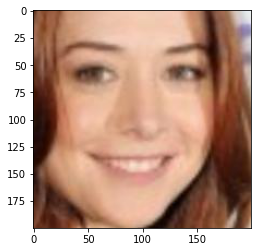

25-49 yrs old
White
Female


In [76]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(198, 198))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

 # This picture should be in the same directory from which the nb is running
picture = "/content/drive/My Drive/8.jpg"                                     
age_pred, race_pred, gender_pred = model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()
max=-1
count=0
for i in age_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1

if temp==0:
  print('0-24 yrs old')
if temp==1:
  print('25-49 yrs old')
if temp==2:
  print('50-74 yrs old')
if temp==3:
  print('75-99 yrs old')
if temp==4:
  print('91-124 yrs old')

max=-1
count=0
for i in race_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1

if temp==0:
  print('White')
if temp==1:
  print('Black')
if temp==2:
  print('Asian')
if temp==3:
  print('Indian')
if temp==4:
  print('Other')

if gender_pred[0][0]>gender_pred[0][1]:
  print('Male')
else:
  print('Female')

# print(age_pred[0],'\n ', race_pred[0],'\n ', gender_pred)